In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
import tensorflow as tf
from collections import Counter
import shutil

In [43]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
SIZE = 450
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = len(os.listdir(train_dir))

In [44]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                
def resample_data1(directory, target_count=200):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)

In [45]:
# Resample training data
resample_data(train_dir)
resample_data1(val_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 3500 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [46]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

# Load the VGG16 model without the top fully connected layers (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 450, 450, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 450, 450, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 450, 450, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 225, 225, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 225, 225, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 225, 225, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 112, 112, 128)     0   

In [47]:
## Metrics callback for precision, recall, F1 score
#class MetricsCallback(Callback):
#    def __init__(self, val_generator):
#        super(MetricsCallback, self).__init__()
#        self.val_generator = val_generator
#
#    def on_epoch_end(self, epoch, logs=None):
#        y_true = self.val_generator.classes
#        y_pred = self.model.predict(self.val_generator)
#        y_pred_classes = np.argmax(y_pred, axis=1)
#
#        precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
#
#        val_loss = logs['val_loss']
#        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions
#
#        print(f'Epoch {epoch + 1} - '
#              f'Validation Loss: {val_loss:.4f}, '
#              f'Validation Accuracy: {val_accuracy:.4f}, '
#              f'Validation Precision: {precision:.4f}, '
#              f'Validation Recall: {recall:.4f}, '
#              f'Validation F1 Score: {f1_score:.4f}')
#
## Early stopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)
#
## Metrics callback
#metrics_callback = MetricsCallback(val_generator)

In [48]:
# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')
        
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)


In [49]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback],
    verbose=2
)

Epoch 1/50
22/22 [==============================] - 15s 700ms/step
Epoch 1 - Validation Loss: 1.9018, Validation Accuracy: 0.2357, Validation Precision: 0.1114
55/55 - 140s - loss: 1.9580 - acc: 0.1646 - val_loss: 1.9018 - val_acc: 0.2357 - 140s/epoch - 3s/step
Epoch 2/50


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


22/22 [==============================] - 15s 708ms/step
Epoch 2 - Validation Loss: 1.8262, Validation Accuracy: 0.3043, Validation Precision: 0.1289
55/55 - 104s - loss: 1.8937 - acc: 0.2126 - val_loss: 1.8262 - val_acc: 0.3043 - 104s/epoch - 2s/step
Epoch 3/50
22/22 [==============================] - 15s 700ms/step
Epoch 3 - Validation Loss: 1.7554, Validation Accuracy: 0.3036, Validation Precision: 0.1615
55/55 - 104s - loss: 1.8217 - acc: 0.2400 - val_loss: 1.7554 - val_acc: 0.3036 - 104s/epoch - 2s/step
Epoch 4/50
22/22 [==============================] - 15s 700ms/step
Epoch 4 - Validation Loss: 1.7173, Validation Accuracy: 0.3521, Validation Precision: 0.1662
55/55 - 104s - loss: 1.7753 - acc: 0.2780 - val_loss: 1.7173 - val_acc: 0.3521 - 104s/epoch - 2s/step
Epoch 5/50
22/22 [==============================] - 15s 700ms/step
Epoch 5 - Validation Loss: 1.6724, Validation Accuracy: 0.3657, Validation Precision: 0.1441
55/55 - 104s - loss: 1.7258 - acc: 0.2763 - val_loss: 1.6724 - va

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


22/22 [==============================] - 15s 709ms/step
Epoch 9 - Validation Loss: 1.6060, Validation Accuracy: 0.3650, Validation Precision: 0.1326
55/55 - 104s - loss: 1.6470 - acc: 0.3383 - val_loss: 1.6060 - val_acc: 0.3650 - 104s/epoch - 2s/step
Epoch 10/50
22/22 [==============================] - 15s 700ms/step
Epoch 10 - Validation Loss: 1.6031, Validation Accuracy: 0.3664, Validation Precision: 0.1449
55/55 - 104s - loss: 1.6194 - acc: 0.3560 - val_loss: 1.6031 - val_acc: 0.3664 - 104s/epoch - 2s/step
Epoch 11/50
22/22 [==============================] - 15s 700ms/step
Epoch 11 - Validation Loss: 1.5835, Validation Accuracy: 0.3993, Validation Precision: 0.1192
55/55 - 104s - loss: 1.6132 - acc: 0.3480 - val_loss: 1.5835 - val_acc: 0.3993 - 104s/epoch - 2s/step
Epoch 12/50
22/22 [==============================] - 15s 700ms/step
Epoch 12 - Validation Loss: 1.6126, Validation Accuracy: 0.3629, Validation Precision: 0.1279
55/55 - 104s - loss: 1.5990 - acc: 0.3566 - val_loss: 1.612

In [50]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')


22/22 [==============================] - 15s 707ms/step
Final Precision: 0.1538
Final Recall: 0.1536
Final F1 Score: 0.1423


24/24 [==============================] - 27s 1s/step - loss: 1.7589 - acc: 0.3135
Test accuracy: 0.3135313391685486


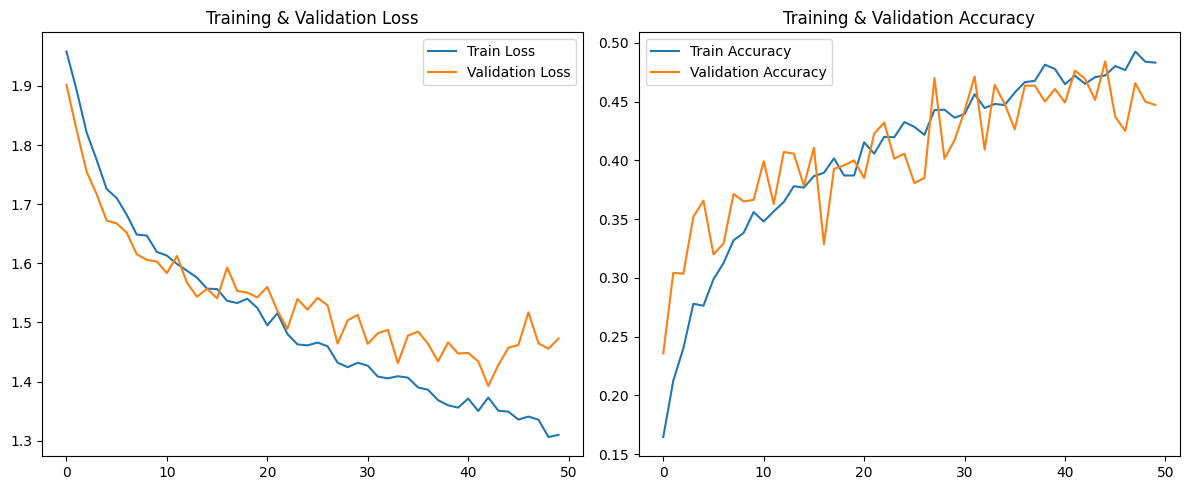

In [51]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

55/55 [==============================] - 72s 1s/step


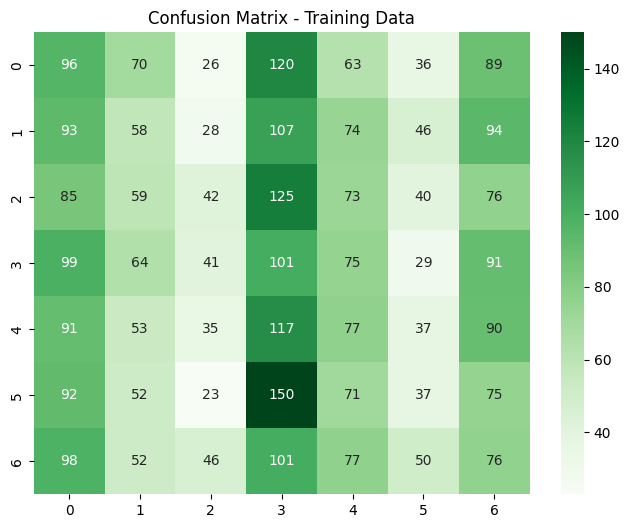

22/22 [==============================] - 15s 696ms/step


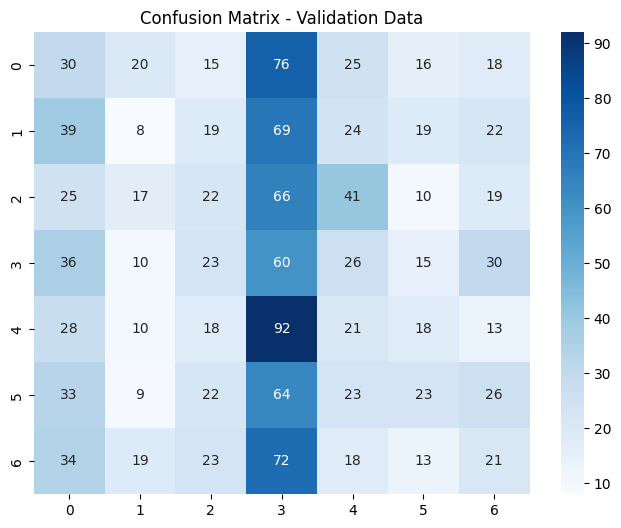

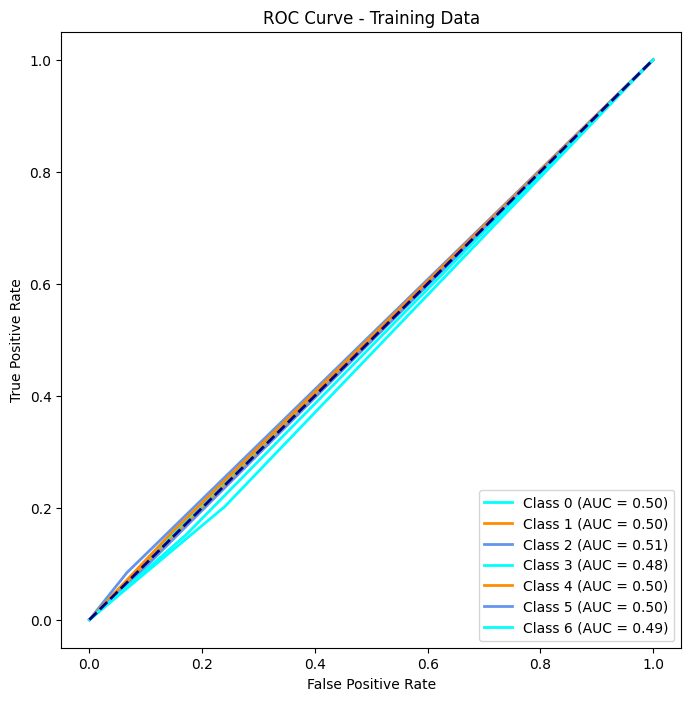

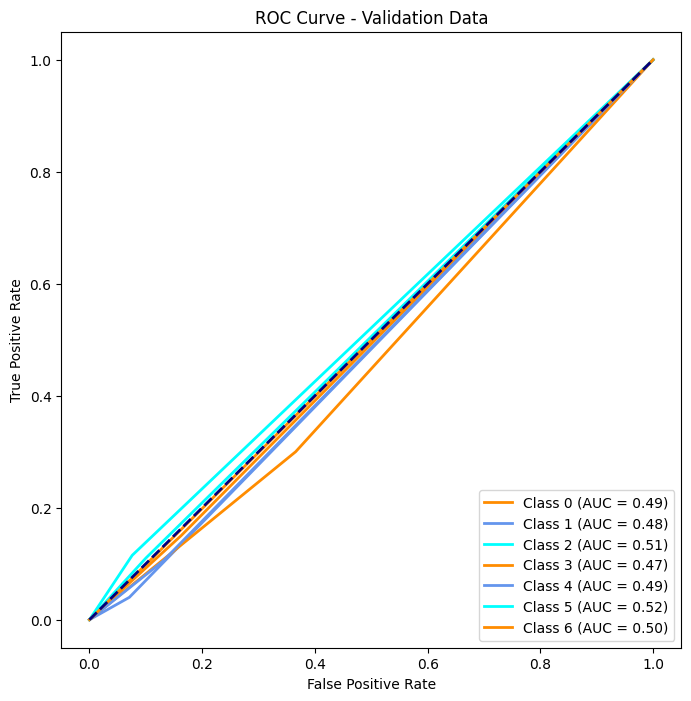

In [53]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()
